In [1]:
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from collections import defaultdict

In [2]:
plt.style.use('seaborn')

In [9]:
base_folder = '../domain_adaptation_results/training_logs/from_scratch_bbn/'
measures_names = ['average_preds',
                  'micro_p', 'micro_r', 'micro_f1',
                  'ma_types_p', 'ma_types_r', 'ma_types_f1',
                  'ma_example_p', 'ma_example_r', 'ma_example_f1',
                  'total_types_pred'
                  ]
header_regex = '[A-z ]+[0-9 ]+:[0-9 ]+:[0-9 ]+ [0-9]+'

rainbow_colors_lines = ['#ff0000', '#ffa500', '#00ff00', '#008000', '#0000ff', '#4b0082', '#ee82ee', '#000000']
rainbow_colors_errors = ['#aa0000', '#aaa500', '#aaf000', '#003000', '#0000aa', '#4b0022', '#9982ee', '#ffffff']

In [10]:
def get_files(s, t, sample_size):
    files = os.listdir(base_folder)
    selected_files = [f for f in files if s in f and t in f and str(sample_size) + '_' in f]
    selected_files.extend([f for f in files if 'from_scratch_{}_k{}_{}.txt'.format(t, sample_size, sample_size) in f])
    selected_files.extend([f for f in files if 'from_scratch_{}_{}_{}.txt'.format(t, sample_size, sample_size) in f])
    return [base_folder + s for s in selected_files]            

In [11]:
def get_measures(file):
    with open(file, 'r') as inp:
        lines = [l.replace('\n', '') for l in inp.readlines()]
    all_measures = {n:[] for n in measures_names}
    measures = {n: [] for n in measures_names}
    matched = False
    for l in lines:
        if re.match(header_regex, l):
            for k, v in all_measures.items():
                if measures[k]:
                    v.append(measures[k])
            measures = {n: [] for n in measures_names}
            matched = True
        elif l == '':
            pass
        else:
            meas = l.split('\t')
            for i, k in enumerate(measures_names):
                measures[k].append(meas[i])
    for k, v in all_measures.items():
        if measures[k]:
            v.append(measures[k])
    return all_measures

In [12]:
def get_epoch_metrics(file_name):
    measures = get_measures(file_name)
    
    epoch_metrics = {k : defaultdict(list) for k in measures_names}

    for k, v in measures.items():
        for sublist in v:
            for i, elem in enumerate(sublist):
                epoch_metrics[k][i].append(float(elem))
    
    epoch_metrics_mean_std = {k: {e: {'mean': np.mean(values), 
                                      'std': np.std(values) if not np.isnan(np.std(values)) else 0} 
                                  for e, values in v.items()} 
                              for k, v in epoch_metrics.items()}
    return epoch_metrics_mean_std

In [13]:
def add_error_bar_to_ax(key, epoch_dict, ax, label, line_color, e_color, err = True):
    x = [i * 10 for i in epoch_dict[key]]
    y = [epoch_dict[key][i]['mean'] for i in epoch_dict[key]]
    yerr = [epoch_dict[key][i]['std'] for i in epoch_dict[key]]
    ax.set_title(key)
    if err:
        ax.errorbar(x=x, y=y, yerr=yerr, label = label, c = line_color, ecolor=e_color)
    else:
        ax.errorbar(x=x, y=y, label = label, c = line_color)
    

In [14]:
def add_errors_to_all_subplots(epoch_dict, label, line_color, e_color, err):
    for i, name in enumerate(measures_names[1 : -1]):
        row = int(np.floor(i/3))
        col = i % 3
        add_error_bar_to_ax(name, epoch_dict, axs[row][col], label, line_color, e_color, err)

# From Scratch Graphs

In [198]:
base_folder = '../domain_adaptation_results/training_logs/s_bbn/t_onto/FTAD/'

dataset = 'figer'

sample_sizes = [20, 50, 100, 200, 500, 1000, 2000, 'all']

In [199]:
epoch_dicts = {}
files = os.listdir(base_folder)
for file in files:
#         if 'from_scratch' in file:
    try:
        epoch_dicts[file.replace(base_folder, '')] = get_epoch_metrics(base_folder + file)
    except:
        pass

In [200]:
files

['FTAD_s_bbn_t_onto_k500_500.txt',
 'FTAD_s_bbn_t_onto_k100_100.txt',
 'FTAD_s_bbn_t_onto_k20_20.txt',
 'FTAD_s_bbn_t_onto_k1000_1000.txt',
 'FTAD_s_bbn_t_onto_k50_50.txt',
 'FTAD_s_bbn_t_onto_k200_200.txt',
 'FTAD_s_bbn_t_onto_k2000_2000.txt']

In [201]:
epoch_dicts

{'FTAD_s_bbn_t_onto_k500_500.txt': {'average_preds': {0: {'mean': 44.91,
    'std': 0.9554318395364455},
   1: {'mean': 39.2375, 'std': 0.8328077509245446},
   2: {'mean': 34.355, 'std': 0.9564125678806212},
   3: {'mean': 29.7475, 'std': 1.1294550677207127},
   4: {'mean': 25.495000000000005, 'std': 1.315779236802284},
   5: {'mean': 21.610000000000003, 'std': 1.4219880449567786},
   6: {'mean': 18.165000000000003, 'std': 1.5282751715577925},
   7: {'mean': 15.14, 'std': 1.5908802594790088},
   8: {'mean': 12.5075, 'std': 1.601551981672777},
   9: {'mean': 10.235, 'std': 1.5788049277855705},
   10: {'mean': 8.3325, 'std': 1.5112805001057878},
   11: {'mean': 6.735, 'std': 1.4081281901872431},
   12: {'mean': 5.42, 'std': 1.2772431248591631},
   13: {'mean': 4.3425, 'std': 1.126129988056441},
   14: {'mean': 3.4975000000000005, 'std': 0.9699323430013043},
   15: {'mean': 2.8425, 'std': 0.8067953581919024},
   16: {'mean': 2.3425000000000002, 'std': 0.6603928754915516},
   17: {'mean': 

In [202]:
def get_early_stop_values(file_name):
    measures = get_measures(file_name)
    
    return {k: {'avg': np.mean([float(s[-6]) for s in sublist]), 
                'std': np.std([float(s[-6]) for s in sublist])
               } 
            for k, sublist in measures.items()}

In [203]:
get_early_stop_values(base_folder + file)

{'average_preds': {'avg': 1.065, 'std': 0.0708872343937891},
 'micro_p': {'avg': 0.6621360000000001, 'std': 0.009104405170026192},
 'micro_r': {'avg': 0.471235, 'std': 0.033739910380734574},
 'micro_f1': {'avg': 0.55004325, 'std': 0.024462550892895434},
 'ma_types_p': {'avg': 0.038853, 'std': 0.022057562580666067},
 'ma_types_r': {'avg': 0.028818749999999997, 'std': 0.017355313140001247},
 'ma_types_f1': {'avg': 0.0329385, 'std': 0.01932551469560384},
 'ma_example_p': {'avg': 0.6640550000000001, 'std': 0.01228164758898413},
 'ma_example_r': {'avg': 0.56754375, 'std': 0.023543709726538426},
 'ma_example_f1': {'avg': 0.6119190000000001, 'std': 0.018733565490850902},
 'total_types_pred': {'avg': 7.25, 'std': 4.602988159880492}}

In [204]:
def print_values(out_path, out_dict, f):
    with open(out_path, 'a') as out:
        out.write('{}\n'.format(f))
        out.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(out_dict['ma_example_f1']['avg'],
                                                                  out_dict['micro_f1']['avg'],
                                                                  out_dict['ma_types_f1']['avg'],
                                                                  out_dict['ma_example_p']['avg'],
                                                                  out_dict['ma_example_r']['avg'],
                                                                  out_dict['micro_p']['avg'],
                                                                  out_dict['micro_r']['avg'],
                                                                  out_dict['ma_types_p']['avg'],
                                                                  out_dict['ma_types_r']['avg'],
                                                                 ))
        out.write('{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\t{:.4f} ± {:.4f}\n'.format(out_dict['ma_example_f1']['avg'],
                                                                                           out_dict['ma_example_f1']['std'],
                                                                  out_dict['micro_f1']['avg'],
                                                                  out_dict['micro_f1']['std'],
                                                                  out_dict['ma_types_f1']['avg'],
                                                                  out_dict['ma_types_f1']['std'],
                                                                  out_dict['ma_example_p']['avg'],
                                                                  out_dict['ma_example_p']['std'],
                                                                  out_dict['ma_example_r']['avg'],
                                                                  out_dict['ma_example_r']['std'],
                                                                  out_dict['micro_p']['avg'],
                                                                  out_dict['micro_p']['std'],
                                                                  out_dict['micro_r']['avg'],
                                                                  out_dict['micro_r']['std'],
                                                                  out_dict['ma_types_p']['avg'],
                                                                  out_dict['ma_types_p']['std'],
                                                                  out_dict['ma_types_r']['avg'],
                                                                  out_dict['ma_types_r']['std'],
                                                                 ))

In [205]:
files

['FTAD_s_bbn_t_onto_k500_500.txt',
 'FTAD_s_bbn_t_onto_k100_100.txt',
 'FTAD_s_bbn_t_onto_k20_20.txt',
 'FTAD_s_bbn_t_onto_k1000_1000.txt',
 'FTAD_s_bbn_t_onto_k50_50.txt',
 'FTAD_s_bbn_t_onto_k200_200.txt',
 'FTAD_s_bbn_t_onto_k2000_2000.txt']

In [206]:
for f in files:
    print_values('out.txt', get_early_stop_values(base_folder + f), f)

In [136]:
epoch_dicts.keys()

dict_keys(['FTAD_s_onto_t_figer_k20_20.txt', 'FTAD_s_onto_t_figer_k1000_1000.txt', 'FTAD_s_onto_t_figer_k200_200.txt', 'FTAD_s_onto_t_figer_k100_100.txt', 'FTAD_s_onto_t_figer_k2000_2000.txt', 'FTAD_s_onto_t_figer_k50_50.txt', 'FTAD_s_onto_t_figer_k500_500.txt'])

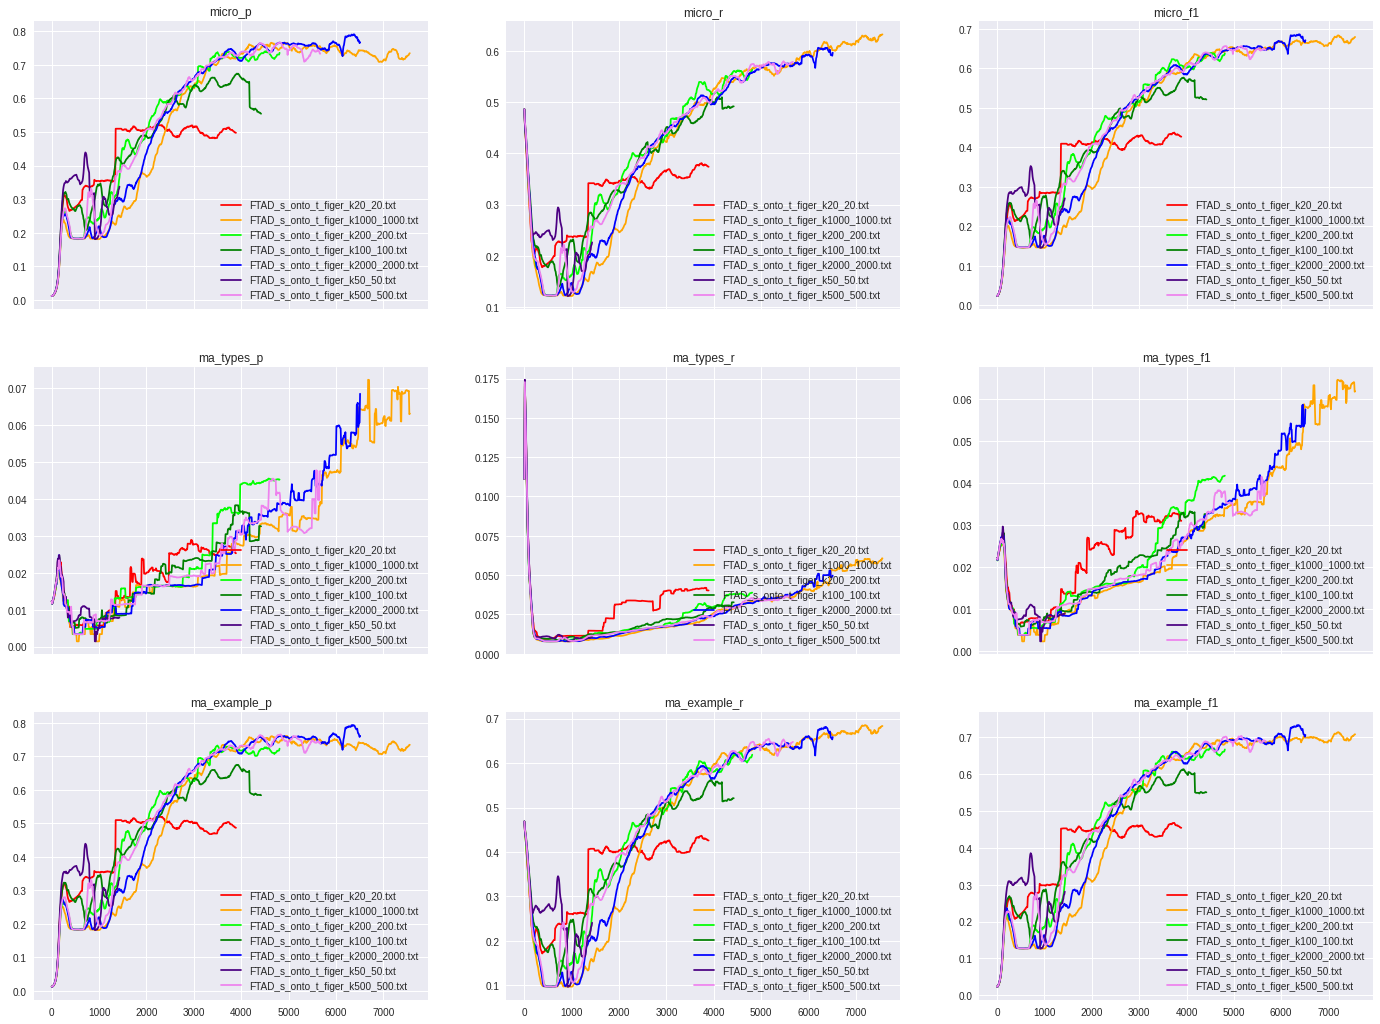

In [139]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True,
                                    figsize=(24, 18))

# fig.suptitle('incremental_training_from_scratch_bbn', fontsize = 48)

for i, (e, v) in enumerate(epoch_dicts.items()):
    
    line_color = rainbow_colors_lines[i]
    e_color = rainbow_colors_errors[i]
        
    add_errors_to_all_subplots(v, e, line_color, e_color, err = False)

for ax in axs:
    for a in ax:
        a.legend(loc='lower right')